# Spectral difference method 2D

Finite Element Method

In [1]:
%pylab inline
import polynomials as poly
from timeit import default_timer as timer
rcParams.update({'font.size': 15})
rcParams.update({'figure.figsize': (6,4)})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


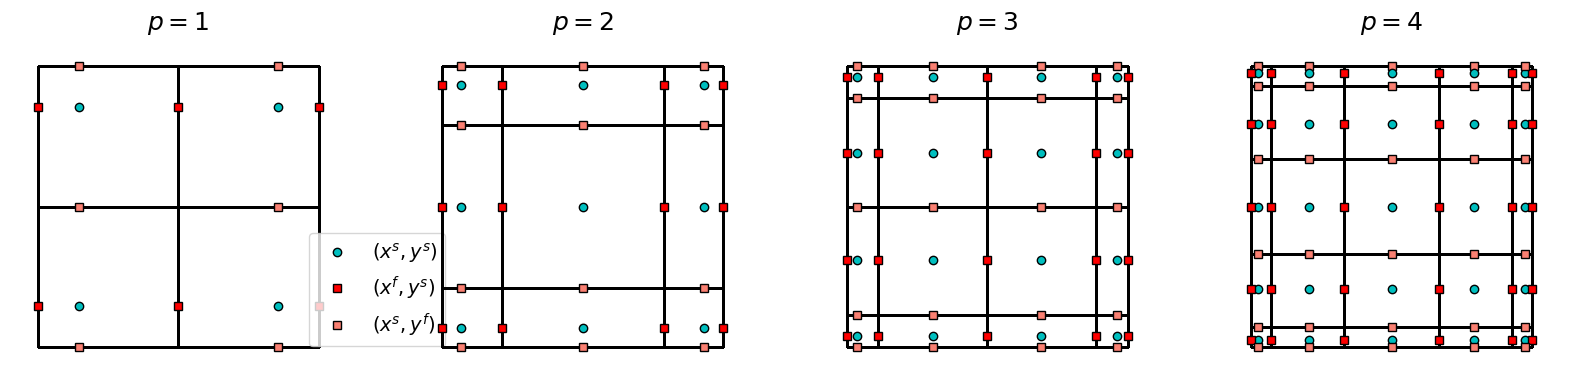

In [2]:
fig,axs = subplots(1,4,figsize=(20,5),sharey=True)
for i in range(4):
    p=i+1
    sca(axs[i])
    x_fp = poly.flux_points(0,1,p)
    x_sp = poly.solution_points(0,1,p)
    x,y = meshgrid(x_fp,x_fp)
    pcolormesh(x,y,zeros([p+1,p+1]),facecolor="none",edgecolor="k")
    for x in x_sp:
        plot(x_sp,x.repeat(p+1),"o",color="c",markeredgecolor="k")
        plot(x_fp,x*np.ones(p+2),"s",color="red",markeredgecolor="k")
        plot(x*np.ones(p+2), x_fp,"s",color="salmon",markeredgecolor="k")
    title(f'$p={i+1}$')
    xlim(-0.1,1.1)
    ylim(-0.1,1.1)
    axs[i].set_aspect("equal")
    axs[i].axis("off")
axs[0].legend(labels=[r"$(x^s,y^s)$",r"$(x^f,y^s)$",r"$(x^s,y^f)$"],fontsize=14,bbox_to_anchor=(0.82, -.05, 0.5, 0.5))  

In [3]:
def solve_riemann(
    U_L: np.ndarray,
    U_R: np.ndarray,
    vel: np.ndarray,
    roll_axis: int,
    *args,
    **kwargs,
) -> None:
    U_R[...] = np.where(
        vel > 0,
        np.roll(U_L, 1, axis=roll_axis),
        U_R,
    )
    U_L[...] = np.roll(U_R, -1, axis=roll_axis)

In [4]:
class SD_Simulator:
    def __init__(
        self,
        init_fct = None,
        n: int = 8,
        Nx: int = 32,
        Ny: int = 32,
        riemann_solver_fct = solve_riemann,
        cfl_coeff: float = 0.8,
        dimension: int = 2,
    ):
        self.n = n
        self.Nx = Nx
        self.Ny = Ny
        self.riemann_solver_fct = riemann_solver_fct
        self.init_fct = init_fct
        self.dimension = dimension
        self.cfl_coeff = cfl_coeff
        
        self.dx = 1.0/self.Nx
        self.dy = 1.0/self.Ny
        self.time = 0
        self.n_step = 0
       
        self.x_fp = poly.flux_points(0.0, 1.0, n)
        self.x_sp = poly.solution_points(0.0, 1.0, n)
        na=np.newaxis
        self.mesh_cv = np.ndarray((2, Ny, Nx, n+2, n+2))
        self.mesh_cv[0] = (np.arange(Nx)[na, :, na, na] + self.x_fp[na, na, na, :])/Nx
        self.mesh_cv[1] = (np.arange(Ny)[:, na, na, na] + self.x_fp[na, na, :, na])/Ny

        self.x_faces, self.x_centers = self.faces_centers(Nx,self.x_fp)
        self.y_faces, self.y_centers = self.faces_centers(Ny,self.x_fp)
        
        self.x_flux = (np.tile(self.x_fp,Nx)+arange(Nx).repeat(n+2))/Nx
        
        # Values at flux pts from values at sol pts.
        self.sp_to_fp = poly.lagrange_matrix(self.x_fp, self.x_sp)
        # Spatial derivative of the flux at sol pts from density at flux pts.
        self.dfp_to_sp = poly.lagrangeprime_matrix(self.x_sp, self.x_fp)
        # Mean values in control volumes from values at sol pts.
        self.sp_to_cv = poly.intfromsol_matrix(self.x_sp, self.x_fp)
        self.cv_to_sp = np.linalg.inv(self.sp_to_cv)

        self.post_init()
        self.compute_dt()

    def post_init(self) -> None:
        self.U_init_cv = poly.quadrature_mean(self.mesh_cv, self.init_fct, 0)
        vx=poly.quadrature_mean(self.mesh_cv, self.init_fct, 1)
        self.velocity_fp_x = np.einsum("fs,ijxs->ijxf", self.sp_to_fp, vx)
        vy=poly.quadrature_mean(self.mesh_cv, self.init_fct, 2)
        self.velocity_fp_y = np.einsum("fs,ijsx->ijfx", self.sp_to_fp, vy)
        
        self.U_init_sp = self.compute_sp_from_cv(self.U_init_cv)

        # Final solution at the current time.
        self.U_cv = self.U_init_cv.copy()
        self.U_sp = self.U_init_sp.copy()

    def compute_sp_from_cv(self,U_cv) -> None:
        # Axes labels:
        #   i,j: cells
        #   k,l: sol pts
        #   m,n: control volumes
        return np.einsum("km,ln,ijmn->ijkl", self.cv_to_sp, self.cv_to_sp, U_cv)

    def compute_cv_from_sp(self,U_sp) -> None:
        # Axes labels:
        #   i,j: cells
        #   k,l: sol pts
        #   m,n: control volumes
        return np.einsum("mk,nl,ijkl->ijmn", self.sp_to_cv, self.sp_to_cv, U_sp)
        
    def compute_dt(self) -> None:
        v_max = np.max(self.velocity_fp_x)+np.max(self.velocity_fp_y)
        self.dt = self.cfl_coeff*self.dx/v_max/(self.n + 1)  
        return self.dt
    
    def faces_centers(self,N,x_fp):
        x_faces = 1/N*np.hstack((np.arange(N).repeat(self.n+1)+np.tile(x_fp[:-1],N),N))  
        x_centers = 0.5*(x_faces[1:]+x_faces[:-1])
        return x_faces,x_centers

In [5]:
def sine_wave(xy: np.ndarray,case: int) -> np.ndarray:
    if case==0:
        return 1.0+0.125*(np.sin(2*np.pi*(xy[0]+xy[1])))
    else:
        return np.ones(xy[0].shape)
    
s = SD_Simulator(n=2,Nx=10,Ny=10,init_fct=sine_wave)

In [6]:
def squash_dimensions(U: np.ndarray):
    return np.transpose(U, (0, 2, 1, 3)).reshape(U.shape[0]*U.shape[2],U.shape[1]*U.shape[3])

def map_solution(s,**kwargs):
    U = squash_dimensions(s.U_cv)
    x,y = meshgrid(s.x_faces,s.y_faces)
    im=pcolormesh(x,y,U,**kwargs)
    xlabel(r'$x$')
    ylabel(r'$y$')
    title(f'$t={round(s.time,2)}$')
    return im

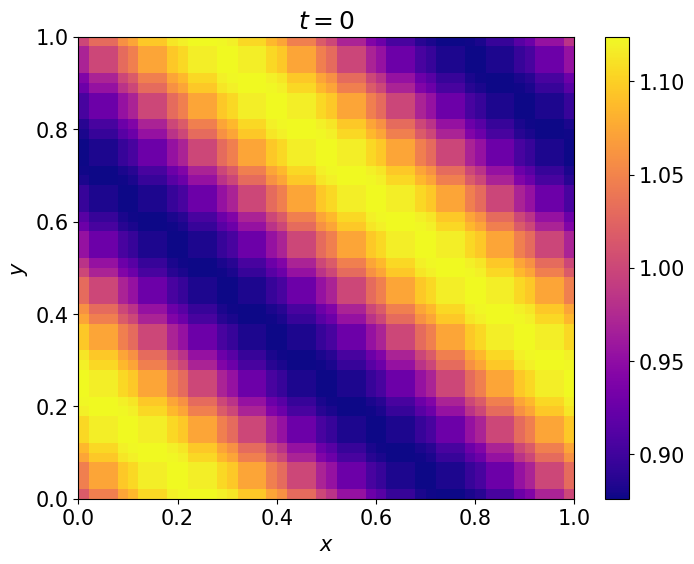

In [7]:
im=map_solution(s,cmap=cm.plasma)
colorbar(im)

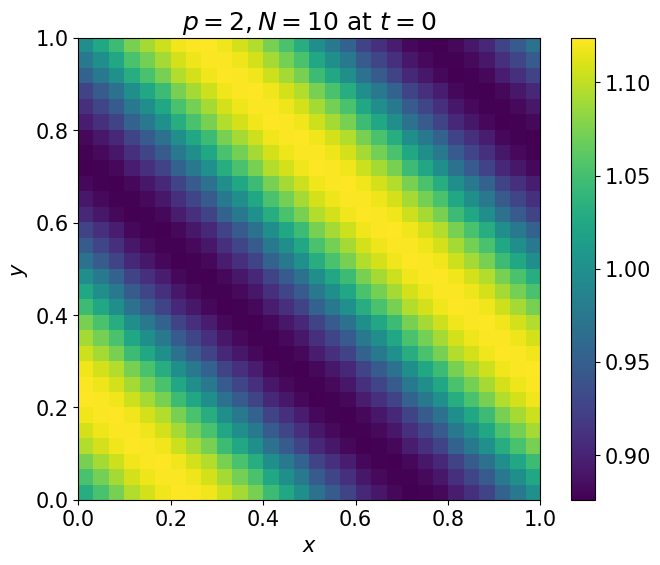

In [8]:
def regular_mesh(s,U):
    #Interpolate to a regular mesh
    n=s.n
    x = np.arange(n+2)/(n+1)
    x = .5*(x[1:]+x[:-1])
    x_sp = poly.solution_points(0.0, 1.0, n)
    m = poly.lagrange_matrix(x, x_sp)
    U_r = np.einsum("mk,nl,ijkl->ijmn", m, m, U)
    return squash_dimensions(U_r)

def regular_map(s,U):
    U = regular_mesh(s,U)
    im=imshow(U,origin="lower",extent=[0,1,0,1])
    xlabel(r'$x$')
    ylabel(r'$y$')
    title(f'$p={s.n}, N={s.Nx}$ at $t={round(s.time,2)}$')
    return im
im=regular_map(s,s.U_cv)
colorbar(im)

In [9]:
def initialize_ader(self):
    # ADER matrix.
    # (*)
    self.x_tp, self.w_tp = poly.gauss_legendre_quadrature(0.0, 1.0, self.n + 1)
    self.ader = poly.ader_matrix(self.x_tp, self.w_tp, 1.0)
    self.invader = np.linalg.inv(self.ader)
    # Axes:
    #   0: ADER substeps
    #   2: cells
    #   3: pts inside cells
    self.U_ader_sp = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+1, self.n+1))
    # Solution at flux points
    self.U_fp_x = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+1, self.n+2))
    self.U_fp_y = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+2, self.n+1))
    # Solution at interfaces between elements

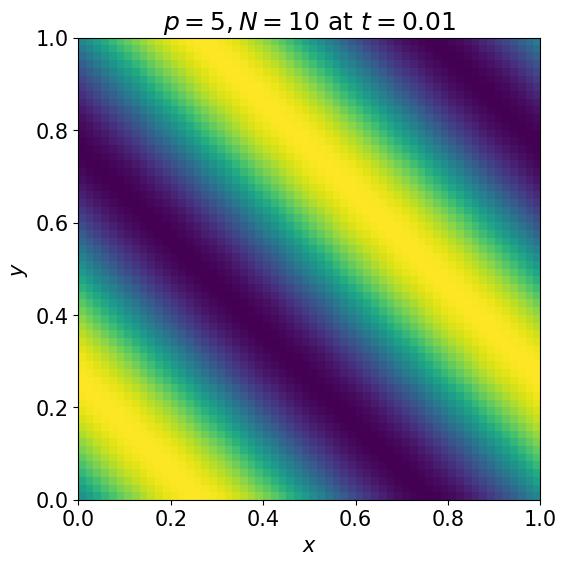

In [10]:
def perform_ader(self) -> None:
    self.n_step += 1
    na = np.newaxis
    # 1) Initialize U_ader_sp to u_sp, at all ADER time substeps.
    self.U_ader_sp[...] = self.U_sp[na]
    
    # 2) ADER scheme (Picard iteration).
    for ader_iter in range(self.n+1):
        # Map sol to flux points.
        # Axes labels:
        #   f: flux pts
        #   s: sol pts
        #   t: ADER substeps
        #   ij: elements

        self.U_fp_x[...] = np.einsum("fs,tijxs->tijxf", self.sp_to_fp, self.U_ader_sp)
        self.U_fp_y[...] = np.einsum("fs,tijsx->tijfx", self.sp_to_fp, self.U_ader_sp)
        # 2b) Solve Riemann problem at cell interfaces.
        #Let's solve for periodic boundaries
        # At interfaces between elements we have
        # u_L | u_R
        # u_L -> last value of each element
        # u_R -> first value of each elemet
        self.riemann_solver_fct(
            self.U_fp_x[...,:,-1],
            self.U_fp_x[...,:,0],
            self.velocity_fp_x[...,:,0],
            -2)
        self.riemann_solver_fct(
            self.U_fp_y[...,-1,:],
            self.U_fp_y[...,0,:],
            self.velocity_fp_y[...,0,:],
            -3)
        
        if ader_iter < self.n:
            # 2c) Compute new iteration value.
            # Axes labels:
            #   n: ADER substeps, next
            #   p: ADER substeps, prev
            #   s: sol pts
            #   f: flux pts
            #   ij: cells
            #Let's store dUdt first
            self.U_ader_sp[...] = self.U_sp[na] - np.einsum(
                "np,p,pijkl->nijkl",
                self.invader,
                self.w_tp,
                (np.einsum(
                    "sf,pijxf->pijxs",
                    self.dfp_to_sp,
                    self.U_fp_x*self.velocity_fp_x
                )/self.dx+
                 np.einsum(
                    "sf,pijfx->pijsx",
                    self.dfp_to_sp,
                    self.U_fp_y*self.velocity_fp_y
                 )/self.dy)
            )*self.dt
    # 3) ADER final update: weighted sum over ADER substeps.
    # Axes labels:
    #   t: ADER substeps
    #   s: sol pts
    #   f: flux pts
    #   ij: cells
    self.U_sp -= np.einsum(
        "t,tijkl->ijkl",
        self.w_tp,
        (np.einsum(
            "sf,pijxf->pijxs",
            self.dfp_to_sp,
            self.U_fp_x*self.velocity_fp_x
        )/self.dx+
         np.einsum(
            "sf,pijfx->pijsx",
            self.dfp_to_sp,
            self.U_fp_y*self.velocity_fp_y
         )/self.dy)
    )*self.dt
    self.time = self.time + self.dt
    self.U_cv[...] = self.compute_cv_from_sp(self.U_sp)
      
s = SD_Simulator(n=5,Nx=10,Ny=10,init_fct=sine_wave)
initialize_ader(s)
perform_ader(s)
regular_map(s,s.U_cv)

p=5, N=10: 76 time steps (Execution time: 1.355075 s)


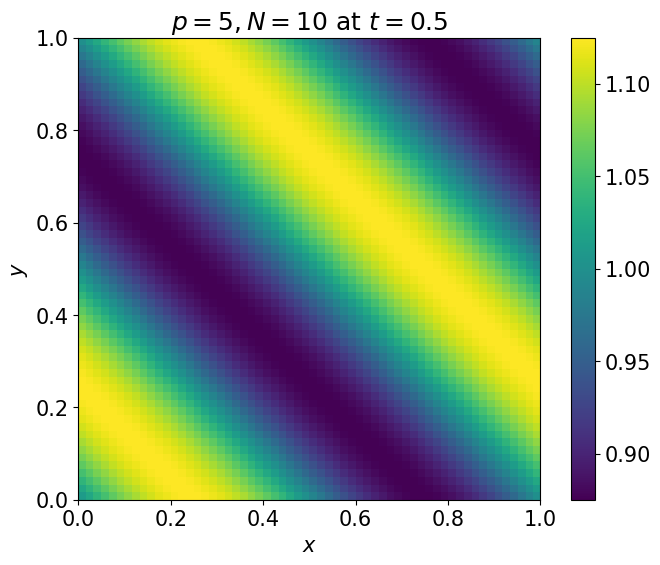

In [11]:
def perform_time_evolution(self, t_end: float) -> None:
    initialize_ader(s)
    self.execution_time = -timer()
    while(self.time < t_end):
        #self.compute_dt()
        if(self.time + self.dt >= t_end):
            self.dt = t_end-self.time
        perform_ader(self)
    self.execution_time += timer() 
    print(f"p={self.n}, N={self.Nx}: {self.n_step} time steps (Execution time: {round(self.execution_time,6)} s)")
s = SD_Simulator(n=5,Nx=10,Ny=10,init_fct=sine_wave)
perform_time_evolution(s,.5)
im=regular_map(s,s.U_cv)
colorbar(im)

In [12]:
from collections import defaultdict

In [13]:
sims=defaultdict(list)
Ns = 2**arange(2,5)
for n in range(1,8):
    for N in Ns:
        s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
        perform_time_evolution(s,1)
        sims[(n,N)] = s

p=1, N=4: 20 time steps (Execution time: 0.00938 s)
p=1, N=8: 40 time steps (Execution time: 0.029743 s)
p=1, N=16: 81 time steps (Execution time: 0.147128 s)
p=2, N=4: 31 time steps (Execution time: 0.028659 s)
p=2, N=8: 61 time steps (Execution time: 0.110053 s)
p=2, N=16: 121 time steps (Execution time: 0.63267 s)
p=3, N=4: 40 time steps (Execution time: 0.062905 s)
p=3, N=8: 81 time steps (Execution time: 0.3115 s)
p=3, N=16: 161 time steps (Execution time: 1.848966 s)
p=4, N=4: 50 time steps (Execution time: 0.130526 s)
p=4, N=8: 100 time steps (Execution time: 0.709773 s)
p=4, N=16: 200 time steps (Execution time: 4.548695 s)
p=5, N=4: 61 time steps (Execution time: 0.257084 s)
p=5, N=8: 121 time steps (Execution time: 1.48401 s)
p=5, N=16: 241 time steps (Execution time: 10.084814 s)
p=6, N=4: 71 time steps (Execution time: 0.479628 s)
p=6, N=8: 141 time steps (Execution time: 2.863665 s)
p=6, N=16: 281 time steps (Execution time: 19.937445 s)
p=7, N=4: 81 time steps (Execution 

/tmp/ipykernel_217611/348006331.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plot(Ns,errors[0]*(Ns[0]/Ns)**(n+1),"", linestyle="--", color="gray", lw=1)


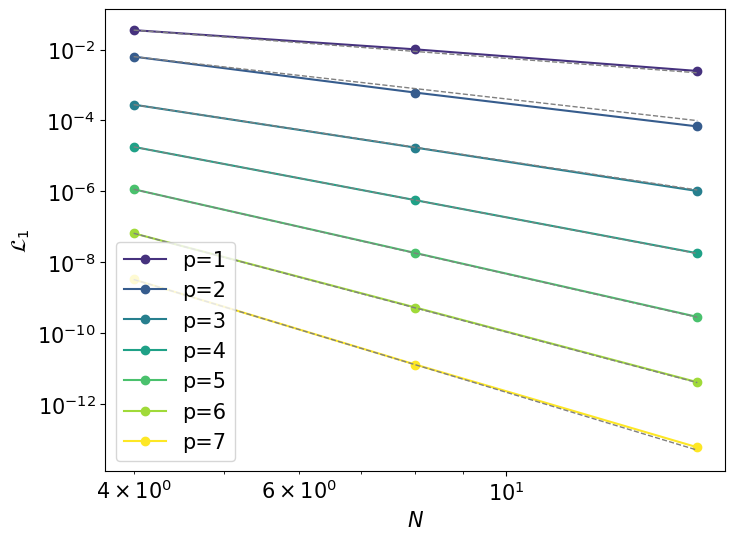

In [14]:
def compute_error(s):
    na=np.newaxis
    dx = (s.x_fp[1:]-s.x_fp[:-1])/s.Nx
    dy = (s.x_fp[1:]-s.x_fp[:-1])/s.Ny
    diff = np.abs(s.U_cv-s.U_init_cv)
    diff *= dx[na,na,na,:]*dy[na,na,:,na] 
    diff=squash_dimensions(diff)
    return math.fsum((diff).ravel())


for n in range(1,8):
    errors=[]
    for N in Ns:
        errors.append(compute_error(sims[(n,N)]))
    loglog(Ns,errors,"-o",color=cm.viridis(n/7),label=f"p={n}")
    plot(Ns,errors[0]*(Ns[0]/Ns)**(n+1),"", linestyle="--", color="gray", lw=1)
ylabel(r"$\mathcal{L}_1$")
xlabel(r"$N$")
legend()      

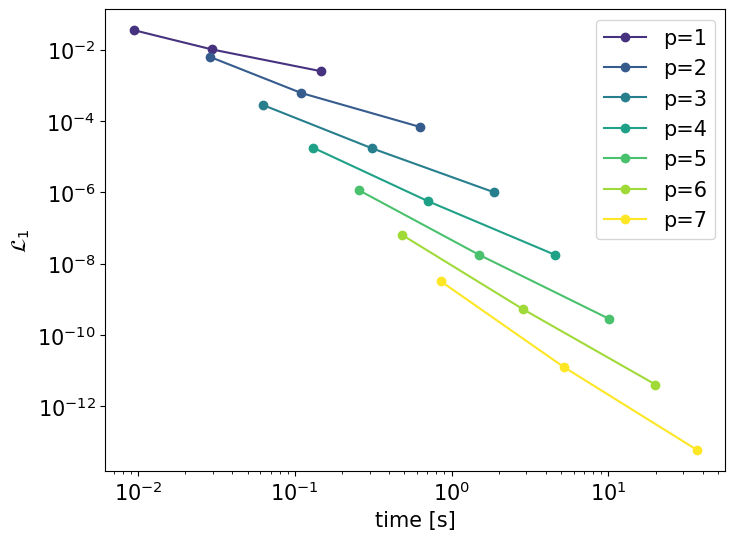

In [15]:
for n in range(1,8):
    errors=[]
    times=[]
    for N in Ns:
        errors.append(compute_error(sims[(n,N)]))
        times.append(sims[(n,N)].execution_time)
    loglog(times,errors,"-o",color=cm.viridis(n/7),label=f"p={n}")
ylabel(r"$\mathcal{L}_1$")
xlabel(r"time [s]")
legend()

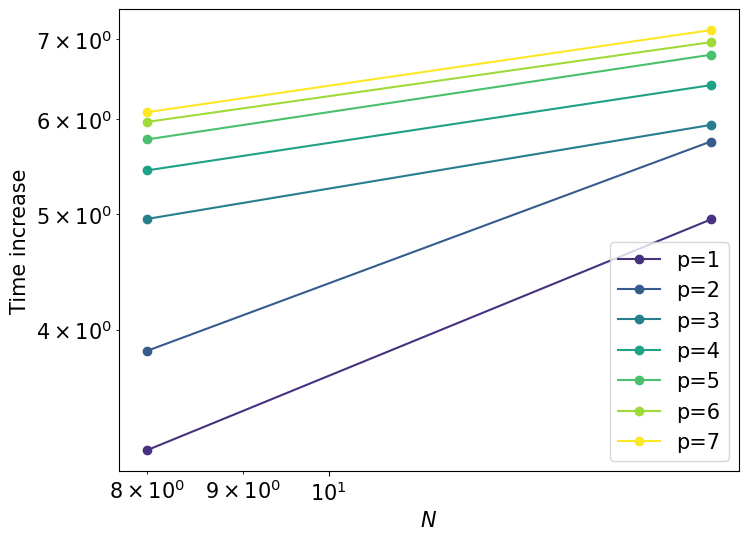

In [16]:
for n in range(1,8):
    times=[]
    for N in Ns:
        times.append(sims[(n,N)].execution_time)
    times=array(times)
    loglog(Ns[1:],times[1:]/times[:-1],"-o",color=cm.viridis(n/7),label=f"p={n}")
ylabel(r"Time increase")
xlabel(r"$N$")
legend()

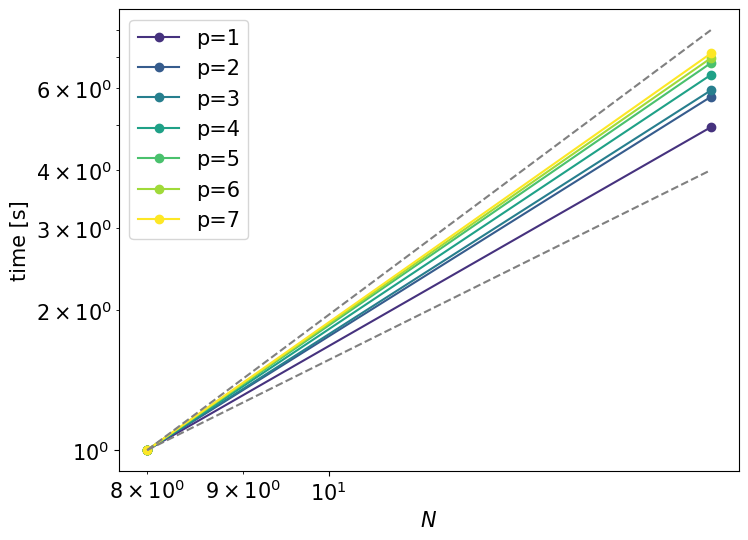

In [17]:
Ns=2**arange(3,5)
for n in range(1,8):
    times=[]
    for N in Ns:
        times.append(sims[(n,N)].execution_time)
    times=array(times)
    loglog(Ns,times/times[0],"-o",color=cm.viridis(n/7),label=f"p={n}")
plot(Ns,(Ns/Ns[0])**3,ls="--",color="gray")
plot(Ns,(Ns/Ns[0])**2,ls="--",color="gray")
ylabel(r"time [s]")
xlabel(r"$N$")
legend()

p=1, N=16: 801 time steps (Execution time: 1.331748 s)
p=3, N=8: 801 time steps (Execution time: 3.129452 s)
p=7, N=4: 801 time steps (Execution time: 8.053544 s)


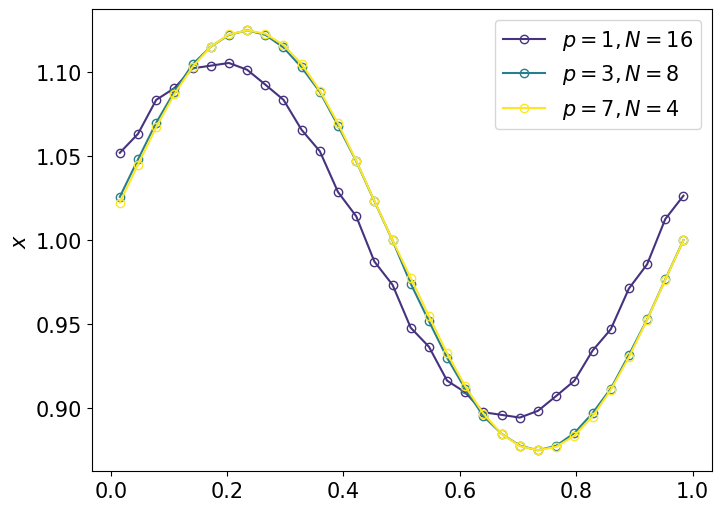

In [18]:
for n in [1,3,7]:
    N=32//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
    perform_time_evolution(s,10)
    u = regular_mesh(s,s.U_cv)
    x = linspace(0,1,s.Nx*(s.n+1)+1)
    x = .5*(x[1:]+x[:-1])
    plot(x,u[0],color=cm.viridis(n/7),label=f"$p={n}, N={N}$",marker="o",fillstyle="none")   
ylabel(r"$u$")
ylabel(r"$x$")
legend()

p=1, N=16: 8000 time steps (Execution time: 14.562653 s)
p=3, N=8: 8000 time steps (Execution time: 31.025455 s)
p=7, N=4: 8000 time steps (Execution time: 85.733575 s)


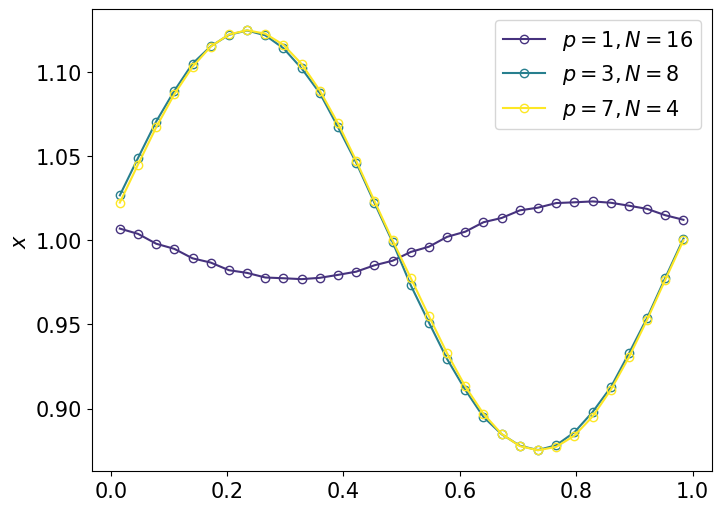

In [19]:
for n in [1,3,7]:
    N=32//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
    perform_time_evolution(s,100)
    u = regular_mesh(s,s.U_cv)
    x = linspace(0,1,s.Nx*(s.n+1)+1)
    x = .5*(x[1:]+x[:-1])
    plot(x,u[0],color=cm.viridis(n/7),label=f"$p={n}, N={N}$",marker="o",fillstyle="none")   
ylabel(r"$u$")
ylabel(r"$x$")
legend()

In [20]:
def step(xy: np.ndarray,ivar: int) -> np.ndarray:
    if ivar==0:
        return np.where(np.fabs(xy[0]-0.5)<0.25,np.where(np.fabs(xy[1]-0.5)<0.25,2,1),1)
    else:
        return np.ones(xy[0].shape)
    
s = SD_Simulator(n=2,Nx=20,Ny=20,init_fct=step)

p=2, N=20: 150 time steps (Execution time: 1.088789 s)


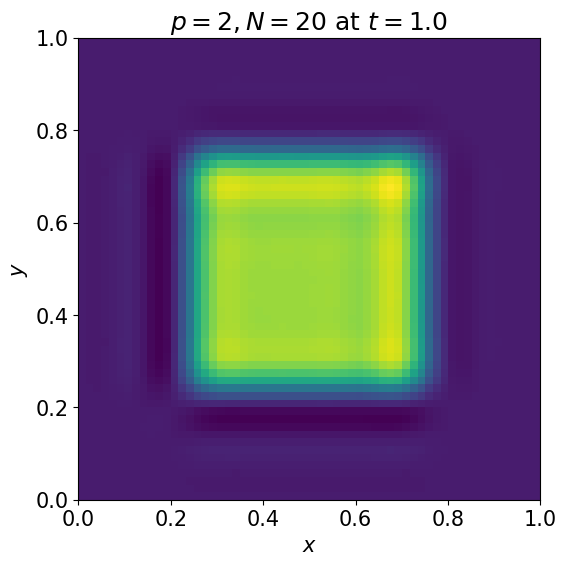

In [21]:
perform_time_evolution(s,1)
regular_map(s,s.U_cv)

p=1, N=32: 161 time steps (Execution time: 0.864124 s)
p=3, N=16: 161 time steps (Execution time: 1.865117 s)
p=7, N=8: 161 time steps (Execution time: 5.151658 s)
p=15, N=4: 161 time steps (Execution time: 19.592683 s)
p=31, N=2: 161 time steps (Execution time: 105.521005 s)
p=63, N=1: 161 time steps (Execution time: 642.108883 s)


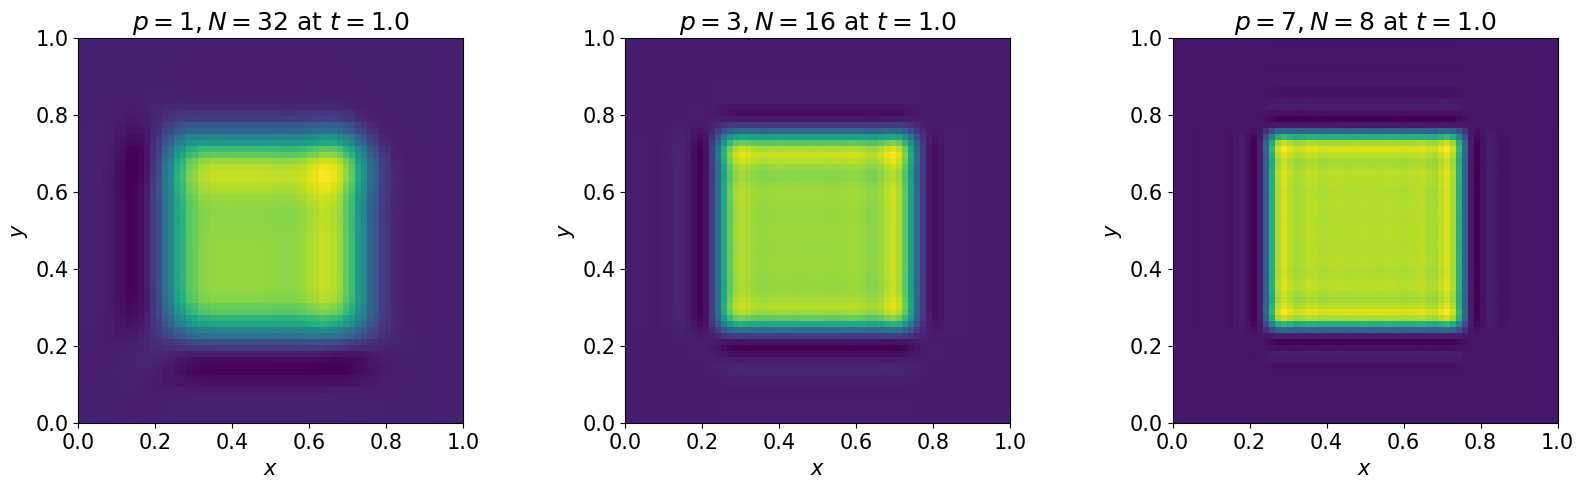

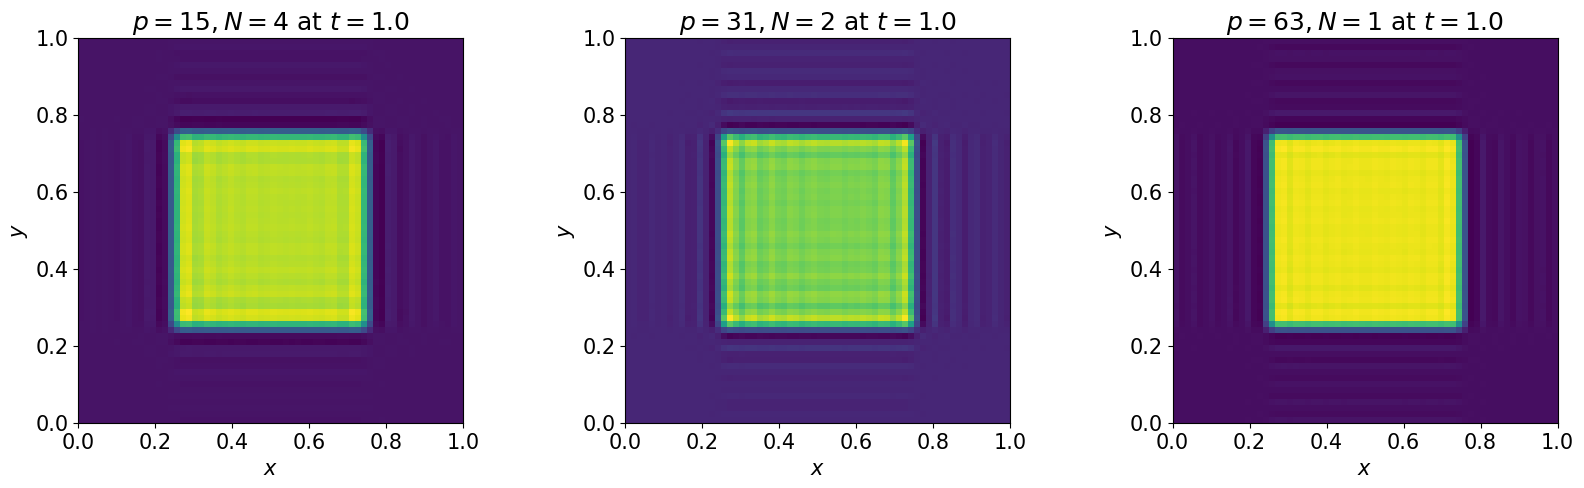

In [22]:
fig,axs = subplots(1,3,figsize=(20,5))
ns=[1,3,7]
N0=64
for i in range(3):
    n=ns[i]
    N=N0//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=step)
    perform_time_evolution(s,1)
    sca(axs[i])
    regular_map(s,s.U_cv)
fig,axs = subplots(1,3,figsize=(20,5))
ns=[15,31,63]
for i in range(3):
    n=ns[i]
    N=N0//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=step)
    perform_time_evolution(s,1)
    sca(axs[i])
    regular_map(s,s.U_cv)